In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from proglearn.forest import UncertaintyForest

# from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from scipy.stats import entropy, norm
from scipy.integrate import quad

# from sklearn.model_selection import GridSearchCV

# import pdb
# %pdb on

import random

n_estimators = 1
posteriors1 = []
posteriors2 = []


In [2]:
# def uf(X, y, n_estimators = 300, max_samples = .4, base = np.exp(1), kappa = 3):
#     frac_eval = 0.3
#     # Build forest with default parameters.
#     model = BaggingClassifier(DecisionTreeClassifier(), 
#                               n_estimators=n_estimators, 
#                               max_samples=(max_samples / (1 - frac_eval)), 
#                               bootstrap=False)
#     X_train, X_eval, y_train, y_eval = train_test_split(X, y , test_size=frac_eval)
#     model.fit(X_train, y_train)
#     n = X_train.shape[0]
#     K = model.n_classes_
#     _, y = np.unique(y, return_inverse=True)
#     cond_entropy = 0
#     for tree_idx, tree in enumerate(model):
#         # Find the indices of the training set used for partition.
#         sampled_indices = model.estimators_samples_[tree_idx]
#         unsampled_indices = np.delete(np.arange(0,n), sampled_indices)
#         # Randomly split the rest into voting and evaluation.
#         # total_unsampled = len(unsampled_indices)
#         # np.random.shuffle(unsampled_indices)
#         # vote_indices = unsampled_indices[:total_unsampled//2]
#         # eval_indices = unsampled_indices[total_unsampled//2:]
#         vote_indices = unsampled_indices
#         # Store the posterior in a num_nodes-by-num_classes matrix.
#         # Posteriors in non-leaf cells will be zero everywhere
#         # and later changed to uniform.
#         node_counts = tree.tree_.n_node_samples
#         class_counts = np.zeros((len(node_counts), K))
#         est_nodes = tree.apply(X_train[vote_indices])
#         est_classes = y_train[vote_indices]
#         for i in range(len(est_nodes)):
#             class_counts[est_nodes[i], est_classes[i]] += 1
#         row_sums = class_counts.sum(axis=1) # Total number of estimation points in each leaf.
#         row_sums[row_sums == 0] = 1 # Avoid divide by zero.
#         class_probs = class_counts / row_sums[:, None]
#         # Make the nodes that have no estimation indices uniform.
#         # This includes non-leaf nodes, but that will not affect the estimate.
#         class_probs[np.argwhere(class_probs.sum(axis = 1) == 0)] = [1 / K]*K
#         # Apply finite sample correction and renormalize.
#         where_0 = np.argwhere(class_probs == 0)
#         for elem in where_0:
#             class_probs[elem[0], elem[1]] = 1 / (kappa*class_counts.sum(axis = 1)[elem[0]])
#         row_sums = class_probs.sum(axis=1)
#         class_probs = class_probs / row_sums[:, None]
#         # Place evaluation points in their corresponding leaf node.
#         # Store evaluation posterior in a num_eval-by-num_class matrix.
#         eval_class_probs = class_probs[tree.apply(X_eval)]
#         eval_class_probs = [class_probs[x] for x in tree.apply(X_eval)]
#         eval_entropies = [entropy(posterior) for posterior in eval_class_probs]
#         cond_entropy += np.mean(eval_entropies)
#     return cond_entropy / n_estimators



# # def uf(X, y, n_estimators = 300, max_samples = .4, base = np.exp(1), kappa = 3):
    
# #     # Build forest with default parameters.
# #     model = BaggingClassifier(DecisionTreeClassifier(), 
# #                               n_estimators=n_estimators, 
# #                               max_samples=max_samples, 
# #                               bootstrap=False)
    
# #     model.fit(X, y)
# #     n = X.shape[0]
# #     K = model.n_classes_
# #     _, y = np.unique(y, return_inverse=True)
    
# #     # # Find the indices of the training set used for partition.
# #     # sampled_indices = model.estimators_samples_[0]
# #     # unsampled_indices = np.delete(np.arange(0,n), sampled_indices)

# #     # # Randomly split the rest into voting and evaluation.
# #     # total_unsampled = len(unsampled_indices)
# #     # np.random.shuffle(unsampled_indices)
# #     # vote_indices = unsampled_indices[:total_unsampled//2]
# #     # eval_indices = unsampled_indices[total_unsampled//2:]
    
# #     cond_entropy = 0
# #     for tree_idx, tree in enumerate(model):
# #         # Find the indices of the training set used for partition.
# #         sampled_indices = model.estimators_samples_[tree_idx]
# #         unsampled_indices = np.delete(np.arange(0,n), sampled_indices)
        
#         # # Randomly split the rest into voting and evaluation.
#         # total_unsampled = len(unsampled_indices)
#         # np.random.shuffle(unsampled_indices)
#         # vote_indices = unsampled_indices[:total_unsampled//2]
#         # eval_indices = unsampled_indices[total_unsampled//2:]
        
#         # # Store the posterior in a num_nodes-by-num_classes matrix.
#         # # Posteriors in non-leaf cells will be zero everywhere
#         # # and later changed to uniform.
#         # node_counts = tree.tree_.n_node_samples
#         # class_counts = np.zeros((len(node_counts), K))
#         # est_nodes = tree.apply(X[vote_indices])
#         # est_classes = y[vote_indices]
#         # for i in range(len(est_nodes)):
#         #     class_counts[est_nodes[i], est_classes[i]] += 1
        
#         # row_sums = class_counts.sum(axis=1) # Total number of estimation points in each leaf.
#         # row_sums[row_sums == 0] = 1 # Avoid divide by zero.
#         # class_probs = class_counts / row_sums[:, None]
        
#         # # Make the nodes that have no estimation indices uniform.
#         # # This includes non-leaf nodes, but that will not affect the estimate.
#         # class_probs[np.argwhere(class_probs.sum(axis = 1) == 0)] = [1 / K]*K
        
#     #     # Apply finite sample correction and renormalize.
#     #     where_0 = np.argwhere(class_probs == 0)
#     #     for elem in where_0:
#     #         class_probs[elem[0], elem[1]] = 1 / (kappa*class_counts.sum(axis = 1)[elem[0]])
#     #     row_sums = class_probs.sum(axis=1)
#     #     class_probs = class_probs / row_sums[:, None]
        
#     #     # Place evaluation points in their corresponding leaf node.
#     #     # Store evaluation posterior in a num_eval-by-num_class matrix.
#     #     eval_class_probs = class_probs[tree.apply(X[eval_indices])]
#     #     # eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
#     #     eval_entropies = [entropy(posterior) for posterior in eval_class_probs]
#     #     cond_entropy += np.mean(eval_entropies)
      
#     # return cond_entropy / n_estimators

In [3]:
def uf(X, y, n_estimators = n_estimators, max_samples = 1, base = np.exp(1), kappa = 3, setseed = 42):
    
    random.seed(setseed)

    frac_eval = 0.3

    ### SPLIT TRANSFORMER/VOTER/EVAL data here 
    X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval, random_state = setseed)

    X_transformer, X_voter, y_transformer, y_voter = train_test_split(X_train, y_train, test_size=(0.3/0.7), random_state = setseed)


    # Build forest with default parameters.
    # model = BaggingClassifier(DecisionTreeClassifier(), 
    #                           n_estimators=n_estimators, 
    #                           max_samples=max_samples, 
    #                           bootstrap=True) #changed from False

    #to match Will's code
    model = DecisionTreeClassifier(random_state=setseed)

                              #change to DecisionTreeClassifier only - because set max samples=1, + fix see
                              #try to match with Will's case
    
    model.fit(X_transformer, y_transformer) #change here to transformer data

    n = X_transformer.shape[0]
    K = model.n_classes_
    _, y = np.unique(y, return_inverse=True)
    
    # # Find the indices of the training set used for partition.
    # sampled_indices = model.estimators_samples_[0]
    # unsampled_indices = np.delete(np.arange(0,n), sampled_indices)

    # # Randomly split the rest into voting and evaluation.
    # total_unsampled = len(unsampled_indices)
    # np.random.shuffle(unsampled_indices)
    # vote_indices = unsampled_indices[:total_unsampled//2]
    # eval_indices = unsampled_indices[total_unsampled//2:]
    
    cond_entropy = 0
    
    node_counts = model.tree_.node_count 
    class_counts = np.zeros((node_counts, K)) #changed due to DecisionTreeClassifier variable node_count
    est_nodes = model.apply(X_voter) #
    est_classes = y_voter
    for i in range(len(est_nodes)):
        class_counts[est_nodes[i], est_classes[i]] += 1
        
    row_sums = class_counts.sum(axis=1) # Total number of estimation points in each leaf.
    row_sums[row_sums == 0] = 1 # Avoid divide by zero.
    class_probs = class_counts / row_sums[:, None]
        
    # Make the nodes that have no estimation indices uniform.
    # This includes non-leaf nodes, but that will not affect the estimate.
    class_probs[np.argwhere(class_probs.sum(axis = 1) == 0)] = [1 / K]*K
        
    # Apply finite sample correction and renormalize.
    where_0 = np.argwhere(class_probs == 0)
    for elem in where_0:
        class_probs[elem[0], elem[1]] = 1 / (kappa*class_counts.sum(axis = 1)[elem[0]])
    row_sums = class_probs.sum(axis=1)
    class_probs = class_probs / row_sums[:, None]

    # print(class_probs)
    # print("end class_probs")
        
    # Place evaluation points in their corresponding leaf node.
    # Store evaluation posterior in a num_eval-by-num_class matrix.
    eval_class_probs = class_probs[model.apply(X_eval)]
    # eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
    eval_entropies = [entropy(posterior) for posterior in eval_class_probs]
    cond_entropy += np.mean(eval_entropies)
      

    # print("uf1 posteriors")
    # print(eval_class_probs)
    # print("end eval_class_probs")

    print("seed number, UF1: {}".format(setseed))

    n_nodes = model.tree_.node_count
    children_left = model.tree_.children_left
    children_right = model.tree_.children_right
    feature = model.tree_.feature
    threshold = model.tree_.threshold

    print("n_nodes = {}".format(n_nodes))
    print("children_left = {}".format(children_left))
    print("children_right = {}".format(children_right))
    print("feature = {}".format(feature))
    print("threshold = {}".format(threshold))
    posteriors1.append(eval_class_probs)
    return cond_entropy / n_estimators
	

In [4]:
def CART_estimate(X, y, n_trees = 300, bootstrap = True):
    model = RandomForestClassifier(bootstrap = bootstrap, n_estimators =n_trees)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree_in_forest in model:
        # get number of training elements in each partition
        node_counts = tree_in_forest.tree_.n_node_samples
        # get counts for all x (x.length array)
        partition_counts = np.asarray([node_counts[x] for x in tree_in_forest.apply(X)])
        # get class probability for all x (x.length, n_classes)
        class_probs = tree_in_forest.predict_proba(X)
        # get elements by performing row wise multiplication
        elems = np.multiply(class_probs, partition_counts[:, np.newaxis])
        # update counts for that tree
        class_counts += elems
    probs = class_counts/class_counts.sum(axis=1, keepdims=True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

## Simulate Data and Conditional Entropy Prediction

In [5]:
def generate_data(n, d, mu = 1):
    n_1 = np.random.binomial(n, .5) # number of class 1
    mean = np.zeros(d)
    mean[0] = mu
    X_1 = np.random.multivariate_normal(mean, np.eye(d), n_1)
    
    X = np.concatenate((X_1, np.random.multivariate_normal(-mean, np.eye(d), n - n_1)))
    y = np.concatenate((np.repeat(1, n_1), np.repeat(0, n - n_1)))
  
    return X, y

## Compute True Conditional Entropy

In [6]:
def true_cond_entropy(mu, base = np.exp(1)):
    def func(x):
        p = 0.5 * norm.pdf(x, mu, 1) + 0.5 * norm.pdf(x, -mu, 1)
        return -p * np.log(p) / np.log(base)
    
    H_X = quad(func, -20, 20)
    H_XY = 0.5*(1.0 + np.log(2 * np.pi)) / np.log(base)
    H_Y = np.log(2.0) / np.log(base)
    # I_XY = H_X - H_XY = H_Y - H_YX
    return H_Y - H_X[0] + H_XY

## Conditional Entropy versus Sample Size

In [7]:
def format_func(value, tick_number):
    epsilon = 10 ** (-5)
    if np.absolute(value) < epsilon:
        return "0"
    if np.absolute(value - 0.5) < epsilon:
        return "0.5"
    if np.absolute(value - 1) < epsilon:
        return "1"
    else:
        return ""

In [8]:
def plot_cond_entropy_by_n(ax, num_plotted_trials, d, mu, algos, panel):
        
    sample_sizes = np.array(pickle.load(open('output/sample_sizes_d_%d.pkl' % d, 'rb')))
    for j, algo in enumerate(algos):
        result = pickle.load(open('output/%s_by_n_d_%d.pkl' % (algo['label'], d), 'rb'))
        # Plot the mean over trials as a solid line.
        ax.plot(sample_sizes,
                np.mean(result, axis = 1).flatten(), 
                label = algo['label'], 
                linewidth = 4, 
                color = algo['color'])
        # Use transparent lines to show other trials.
        for t in range(num_plotted_trials):
            ax.plot(sample_sizes, 
                    result[:, t].flatten(),  
                    linewidth = 2, 
                    color = algo['color'],
                    alpha = 0.15)
    
    truth = true_cond_entropy(mu)
    ax.axhline(y = truth, linestyle = '-', color = "black", label = "Truth")
        
    ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
    ax.set_xlabel("Sample Size")
    ax.set_ylabel("Estimated Conditional Entropy")
    ax.set_title("%s) Effect Size = %.1f" % (panel, mu))
    ax.set_ylim(ymin = -0.05, ymax = 1.05)

## Conditional Entropy Estimates versus Effect Size

In [9]:
def plot_cond_entropy_by_mu(ax, d, n, algos, panel):
    
    mus = pickle.load(open('output/mus.pkl', 'rb'))
    for j, algo in enumerate(algos):
        result = pickle.load(open('output/%s_by_mu_d_%d.pkl' % (algo['label'], d), 'rb'))
        # Plot the mean over trials as a solid line.
        ax.plot(mus,
                np.mean(result, axis = 1).flatten(), 
                label = algo['label'], 
                linewidth = 4, 
                color = algo['color'])
    
    truth = [true_cond_entropy(mu) for mu in mus]
    ax.plot(mus, truth, label = 'Truth', linewidth = 4, color = 'black')

    ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
    ax.set_ylim(ymin = -.05)
    ax.set_title("%s) n = %d" % (panel, n))
    ax.set_xlabel("Effect Size")
    ax.set_ylabel("Estimated Conditional Entropy")

In [10]:
def plot_fig2(num_plotted_trials, d1, d2, n1, n2, effect_size, algos):
    sns.set(font_scale = 3)
    sns.set_style("ticks")
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams['figure.figsize'] = [30, 20]
    fig, axes = plt.subplots(2, 2)
    
    plot_cond_entropy_by_n(axes[0, 0], num_plotted_trials, d1, effect_size, algos, "A")
    plot_cond_entropy_by_mu(axes[0, 1], d1, n1, algos, "B")
    
    plot_cond_entropy_by_n(axes[1, 0], num_plotted_trials, d2, effect_size, algos, "C") 
    plot_cond_entropy_by_mu(axes[1, 1], d2, n2, algos, "D")
    
    axes[0,0].legend(loc = "upper left", prop={'size': 12})#edited font size to fit many lines
    
    fig.text(-0.05, 0.27, 'd = %d' % d2, ha='left', va='center', fontsize = 40)
    fig.text(-0.05, 0.77, 'd = %d' % d1, ha='left', va='center', fontsize = 40)
    
    plt.subplots_adjust(left=-1)
    plt.tight_layout()
    plt.savefig("fig2.pdf", bbox_inches = "tight")
    plt.show()

In [11]:
def get_cond_entropy_vs_n(mean, d, num_trials, sample_sizes, algos):
    
    def worker(t):
        X, y = generate_data(elem, d, mu = mean)
        
        ret = []
        for algo in algos:
            ret.append(estimate_ce(X, y, algo['label']))

        return tuple(ret)
    
    output = np.zeros((len(algos), len(sample_sizes), num_trials))
    for i, elem in enumerate(sample_sizes):
        # results = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
        results = []
        for t in range(num_trials):
            print(t)
            results.append(worker(t))
        results = np.array(results)
        for j in range(len(algos)):
            output[j, i, :] = results[:, j]
        
    pickle.dump(sample_sizes, open('output/sample_sizes_d_%d.pkl' % d, 'wb'))
    for j, algo in enumerate(algos):
        pickle.dump(output[j], open('output/%s_by_n_d_%d.pkl' % (algo['label'], d), 'wb'))
        
    return output

In [12]:
def estimate_ce(X, y, label):
    if label == "CART":
        return CART_estimate(X, y)
    elif label == "IRF":
        frac_eval = 0.3
        irf = CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators = 300), 
                                     method='isotonic', 
                                     cv = 5)
        # X_train, y_train, X_eval, y_eval = split_train_eval(X, y, frac_eval)
        X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval)
        irf.fit(X_train, y_train)
        p = irf.predict_proba(X_eval)
        return np.mean(entropy(p.T, base = np.exp(1)))
    elif label == "UF":
        return uf(X, y, base = np.exp(1), kappa = 3, setseed=42)
    elif label == "UF2":
        setseed = 42
        frac_eval = 0.3
        frac_vote = 0.3 / (1 - frac_eval) # 30% of the original data.
        kappa = 3
        X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval, random_state=setseed)
        uf2 = UncertaintyForest(n_estimators = n_estimators, kappa = kappa, frac_vote = frac_vote) #changed to match UF
        uf2.fit(X_train, y_train)
        p = uf2.predict_proba(X_eval)
        print("seed number, UF2: {}".format(setseed))

        n_nodes = model.tree_.node_count
        children_left = model.tree_.children_left
        children_right = model.tree_.children_right
        feature = model.tree_.feature
        threshold = model.tree_.threshold

        print("n_nodes = {}".format(n_nodes))
        print("children_left = {}".format(children_left))
        print("children_right = {}".format(children_right))
        print("feature = {}".format(feature))
        print("threshold = {}".format(threshold))
        posteriors2.append(p)
        return np.mean(entropy(p.T, base = np.exp(1)))    
    else:
        raise ValueError("Unrecognized Label!")

In [13]:
def get_cond_entropy_vs_mu(n, d, num_trials, mus, algos):
    
    def worker(t):
        X, y = generate_data(n, d, mu = elem)
        
        ret = []
        for algo in algos:
            ret.append(estimate_ce(X, y, algo['label']))

        return tuple(ret)
    
    output = np.zeros((len(algos), len(mus), num_trials))
    for i, elem in enumerate(mus):
        # results = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
        results = []
        for t in range(num_trials):
            print(t)
            results.append(worker(t))
        results = np.array(results)
        for j in range(len(algos)):
            output[j, i, :] = results[:, j]
    
    pickle.dump(mus, open('output/mus.pkl', 'wb'))
    for j, algo in enumerate(algos):
        pickle.dump(output[j], open('output/%s_by_mu_d_%d.pkl' % (algo['label'], d), 'wb'))
        
    return output

## Run Experiments and Plot

In [14]:
# Data.
# mus = [i * 0.5 for i in range(1, 11)]
# effect_size = 1
# d1 = 1
# d2 = 20
# n1 = 3000
# n2 = 6000
# num_trials = 50 # 20
# num_plotted_trials = 10
# sample_sizes_d1 = range(300, 1201, 90)
# sample_sizes_d2 = range(500, 3001, 250)

# Fake params.
mus = [i * 0.5 for i in range(1, 3)]
effect_size = 1
d1 = 1
d2 = 3
n1 = 100
n2 = 110
num_trials = 10 #2
num_plotted_trials = 10 #2
sample_sizes_d1 = range(100, 120, 10)
sample_sizes_d2 = range(100, 130, 10)


# Algorithms.
algos = [
#     {
#         'label': 'CART',
#         'title': 'CART Forest',
#         'color': "#1b9e77",
#     },
#     {
#         'label': 'IRF',
#         'title': 'Isotonic Reg. Forest',
#         'color': "#fdae61",
#     },
    {
        'label': 'UF',
        'title': 'Uncertainty Forest',
        'color': "#F41711",
    },
    {
        'label': 'UF2',
        'title': 'Uncertainty Forest 2',
        'color': "#0000FF",
    }
#     {
#         'label': 'UF K=0.1',
#         'title': 'Uncertainty Forest',
#         'color': "#F41711",
#     },
#     {
#         'label': 'UF K=0.3',
#         'title': 'Uncertainty Forest',
#         'color': "#FF9A33",
#     },
#     {
#         'label': 'UF K=1',
#         'title': 'Uncertainty Forest',
#         'color': "#FFD533",
#     },
#     {
#         'label': 'UF K=3',
#         'title': 'Uncertainty Forest',
#         'color': "#F9FF33",
#     },
#     {
#         'label': 'UF K=10',
#         'title': 'Uncertainty Forest',
#         'color': "#90FF33",
#     },
#     {
#         'label': 'UF2 K=0.1 frac_vote=0.3 evalsplit',
#         'title': 'Uncertainty Forest 2',
#         'color': "#33FFF8",
#     },
#     {
#         'label': 'UF2 K=0.3 frac_vote=0.3 evalsplit',
#         'title': 'Uncertainty Forest 2',
#         'color': "#33A4FF",
#     },
#     {
#         'label': 'UF2 K=1 frac_vote=0.3 evalsplit',
#         'title': 'Uncertainty Forest 2',
#         'color': "#3B33FF",
#     },
#     {
#         'label': 'UF2 K=3 frac_vote=0.3 evalsplit',
#         'title': 'Uncertainty Forest 2',
#         'color': "#B433FF",
#     },
#     {
#         'label': 'UF2 K=10 frac_vote=0.3 evalsplit',
#         'title': 'Uncertainty Forest 2',
#         'color': "#FF33D5",
#     },
#     {
#         'label': 'UF2 K=3 frac_vote=0.2 evalsplit',
#         'title': 'Uncertainty Forest 2',
#         'color': "#33A4FF",
#     },
#     {
#         'label': 'UF2 K=3 frac_vote=0.3 evalsplit',
#         'title': 'Uncertainty Forest 2',
#         'color': "#3B33FF",
#     },
#     {
#         'label': 'UF2 K=3 frac_vote=0.4 evalsplit',
#         'title': 'Uncertainty Forest 2',
#         'color': "#B433FF",
#     },
#     {
#         'label': 'UF2 K=3 frac_vote=0.5 evalsplit',
#         'title': 'Uncertainty Forest 2',
#         'color': "#FF33D5",
#     },
#     {
#         'label': 'UF2 K=10 frac_vote=0.2 evalsplit',
#         'title': 'Uncertainty Forest 2',
#         'color': "#33A4FF",
#     },
#     {
#         'label': 'UF2 K=10 frac_vote=0.3 evalsplit',
#         'title': 'Uncertainty Forest 2',
#         'color': "#3B33FF",
#     },
#     {
#         'label': 'UF2 K=10 frac_vote=0.4 evalsplit',
#         'title': 'Uncertainty Forest 2',
#         'color': "#B433FF",
#     },
#     {
#         'label': 'UF2 K=10 frac_vote=0.5 evalsplit',
#         'title': 'Uncertainty Forest 2',
#         'color': "#FF33D5",
#     },
#     {
#         'label': 'UF2 K=0.1 frac_vote=0.3 eval_notsplit',
#         'title': 'Uncertainty Forest 2',
#         'color': "#33FFF8",
#     },
#     {
#         'label': 'UF2 K=0.3 frac_vote=0.3 eval_notsplit',
#         'title': 'Uncertainty Forest 2',
#         'color': "#33A4FF",
#     },
#     {
#         'label': 'UF2 K=1 frac_vote=0.3 eval_notsplit',
#         'title': 'Uncertainty Forest 2',
#         'color': "#3B33FF",
#     },
#     {
#         'label': 'UF2 K=3 frac_vote=0.3 eval_notsplit',
#         'title': 'Uncertainty Forest 2',
#         'color': "#B433FF",
#     },
#     {
#         'label': 'UF2 K=10 frac_vote=0.3 eval_notsplit',
#         'title': 'Uncertainty Forest 2',
#         'color': "#FF33D5",
#     },
#     {
#         'label': 'UF2 K=10 frac_vote=0.2 eval_notsplit',
#         'title': 'Uncertainty Forest 2',
#         'color': "#33A4FF",
#     },
#     {
#         'label': 'UF2 K=10 frac_vote=0.4 eval_notsplit',
#         'title': 'Uncertainty Forest 2',
#         'color': "#B433FF",
#     },
#     {
#         'label': 'UF2 K=10 frac_vote=0.5 eval_notsplit',
#         'title': 'Uncertainty Forest 2',
#         'color': "#3B33FF",
#     },
]

### Estimated H(Y | X) versus n, d = 1

In [15]:
get_cond_entropy_vs_n(effect_size, d1, num_trials, sample_sizes_d1, algos)

0
seed number, UF1: 42
n_nodes = 11
children_left = [ 1 -1  3  4  5 -1  7 -1 -1 -1 -1]
children_right = [ 2 -1 10  9  6 -1  8 -1 -1 -1 -1]
feature = [ 0 -2  0  0  0 -2  0 -2 -2 -2 -2]
threshold = [-0.6077998  -2.          0.07392374 -0.14888266 -0.50056595 -2.
 -0.41086045 -2.         -2.         -2.         -2.        ]
seed number, UF2: 42


NameError: name 'model' is not defined

### Estimated H(Y | X) versus mu, d = 1

In [16]:
# Estimate conditional entropy vs mu.
get_cond_entropy_vs_mu(n1, d1, num_trials, mus, algos)

0
seed number, UF1: 42
n_nodes = 33
children_left = [ 1  2 -1  4 -1  6 -1  8  9 10 11 12 13 -1 -1 -1 17 -1 19 -1 -1 -1 -1 -1
 25 26 -1 28 29 -1 -1 -1 -1]
children_right = [24  3 -1  5 -1  7 -1 23 22 21 16 15 14 -1 -1 -1 18 -1 20 -1 -1 -1 -1 -1
 32 27 -1 31 30 -1 -1 -1 -1]
feature = [ 0  0 -2  0 -2  0 -2  0  0  0  0  0  0 -2 -2 -2  0 -2  0 -2 -2 -2 -2 -2
  0  0 -2  0  0 -2 -2 -2 -2]
threshold = [ 0.24564879 -2.70559371 -2.         -1.63448179 -2.         -1.28410465
 -2.         -0.10196401 -0.22344135 -0.41921733 -0.51824123 -0.96600592
 -1.03514862 -2.         -2.         -2.         -0.49335544 -2.
 -0.47899067 -2.         -2.         -2.         -2.         -2.
  0.83538973  0.50174582 -2.          0.69080982  0.5895943  -2.
 -2.         -2.         -2.        ]
1
seed number, UF1: 42
n_nodes = 35
children_left = [ 1  2  3  4  5 -1 -1  8 -1 10 -1 12 -1 14 -1 -1 -1 18 -1 20 -1 22 23 24
 -1 -1 -1 28 -1 30 -1 32 -1 -1 -1]
children_right = [34 17 16  7  6 -1 -1  9 -1 11 -1 13 -1 15 -1 -

array([[[0.52571019, 0.62805599, 0.53526302, 0.54660747, 0.54345919,
         0.53962832, 0.43369178, 0.56249896, 0.55794745, 0.39177896],
        [0.3586546 , 0.35174286, 0.37644941, 0.39612979, 0.47399702,
         0.41119238, 0.39825112, 0.39375984, 0.39088365, 0.42526053]],

       [[0.61835674, 0.66073478, 0.65541009, 0.54528712, 0.44035305,
         0.48541433, 0.58344891, 0.53931408, 0.5952965 , 0.52129154],
        [0.40099698, 0.41878275, 0.35636962, 0.43077096, 0.49309444,
         0.42434094, 0.49577714, 0.30409048, 0.2662919 , 0.42603362]]])

### Estimated H(Y | X) versus n, d = 40

In [17]:
# Estimate conditional entropy vs n.
get_cond_entropy_vs_n(effect_size, d2, num_trials, sample_sizes_d2, algos)

0
seed number, UF1: 42
n_nodes = 13
children_left = [ 1  2 -1  4 -1  6 -1 -1  9 -1 11 -1 -1]
children_right = [ 8  3 -1  5 -1  7 -1 -1 10 -1 12 -1 -1]
feature = [ 0  2 -2  0 -2  2 -2 -2  1 -2  1 -2 -2]
threshold = [ 0.24414016 -1.53141135 -2.         -0.33519827 -2.         -0.25636178
 -2.         -2.          1.67465454 -2.          2.06105739 -2.
 -2.        ]
1
seed number, UF1: 42
n_nodes = 17
children_left = [ 1  2 -1 -1  5  6 -1 -1  9 -1 11 -1 13 -1 15 -1 -1]
children_right = [ 4  3 -1 -1  8  7 -1 -1 10 -1 12 -1 14 -1 16 -1 -1]
feature = [ 0  1 -2 -2  1  2 -2 -2  2 -2  2 -2  1 -2  1 -2 -2]
threshold = [-0.36302805  1.9826529  -2.         -2.         -0.79054618 -0.27547494
 -2.         -2.         -0.03319326 -2.          0.13139542 -2.
  0.2404025  -2.          0.47170135 -2.         -2.        ]
2
seed number, UF1: 42
n_nodes = 13
children_left = [ 1  2  3 -1  5 -1 -1  8 -1 10 -1 -1 -1]
children_right = [12  7  4 -1  6 -1 -1  9 -1 11 -1 -1 -1]
feature = [ 0  2  1 -2  2 -2 -2  

array([[[0.45141137, 0.47064794, 0.43705497, 0.50668362, 0.2553617 ,
         0.46852897, 0.46111333, 0.38266713, 0.4681367 , 0.33086446],
        [0.43550674, 0.32380487, 0.30939692, 0.41931112, 0.53175897,
         0.51475958, 0.38146375, 0.48685907, 0.48802235, 0.26967094],
        [0.42010486, 0.21370713, 0.5148615 , 0.47094493, 0.37826488,
         0.36081713, 0.48352268, 0.39154412, 0.54617421, 0.33040132]],

       [[0.33998456, 0.6078677 , 0.41012504, 0.38257957, 0.22975614,
         0.48549084, 0.44536527, 0.37310837, 0.35158878, 0.36712293],
        [0.34518122, 0.30358614, 0.41844094, 0.48690871, 0.51212982,
         0.43175839, 0.55693457, 0.35703023, 0.35669628, 0.24316819],
        [0.39197805, 0.38651956, 0.22019586, 0.47886472, 0.35997214,
         0.38031247, 0.44843215, 0.47092641, 0.37418856, 0.43762634]]])

In [18]:
### Estimated H(Y | X) versus mu, d = 40

In [19]:
# Estimate conditional entropy vs mu.
get_cond_entropy_vs_mu(n2, d2, num_trials, mus, algos)

0
seed number, UF1: 42
n_nodes = 27
children_left = [ 1  2  3  4  5  6  7 -1 -1 -1 -1 12 -1 -1 -1 -1 17 -1 19 -1 21 22 -1 24
 -1 -1 -1]
children_right = [16 15 14 11 10  9  8 -1 -1 -1 -1 13 -1 -1 -1 -1 18 -1 20 -1 26 23 -1 25
 -1 -1 -1]
feature = [ 0  2  2  1  2  1  2 -2 -2 -2 -2  1 -2 -2 -2 -2  2 -2  2 -2  1  2 -2  2
 -2 -2 -2]
threshold = [ 0.26015367  1.10127544  0.77565697  1.19136924 -0.30543952  0.60441217
 -0.49341731 -2.         -2.         -2.         -2.          1.67324632
 -2.         -2.         -2.         -2.         -0.22730003 -2.
  0.26980399 -2.          2.20264798  1.12277818 -2.          1.48764729
 -2.         -2.         -2.        ]
1
seed number, UF1: 42
n_nodes = 23
children_left = [ 1  2  3  4 -1  6 -1  8 -1 -1 11 -1 13 -1 -1 16 17 -1 -1 -1 21 -1 -1]
children_right = [20 15 10  5 -1  7 -1  9 -1 -1 12 -1 14 -1 -1 19 18 -1 -1 -1 22 -1 -1]
feature = [ 0  2  2  0 -2  1 -2  1 -2 -2  0 -2  1 -2 -2  1  2 -2 -2 -2  2 -2 -2]
threshold = [ 1.08172339  0.60616735 -1.303

array([[[0.58669165, 0.54518018, 0.51615912, 0.64735903, 0.59126245,
         0.66365408, 0.57012996, 0.50835981, 0.56926996, 0.6274783 ],
        [0.40697496, 0.43175356, 0.51935319, 0.45057325, 0.36884442,
         0.55501855, 0.53564473, 0.49800517, 0.52273061, 0.51656929]],

       [[0.58991649, 0.65048812, 0.54756975, 0.61008272, 0.57025255,
         0.63089232, 0.48757932, 0.49300229, 0.62079881, 0.59896497],
        [0.34006374, 0.52857524, 0.4543638 , 0.38533871, 0.49397802,
         0.55854988, 0.51386815, 0.5652396 , 0.5298679 , 0.54604206]]])

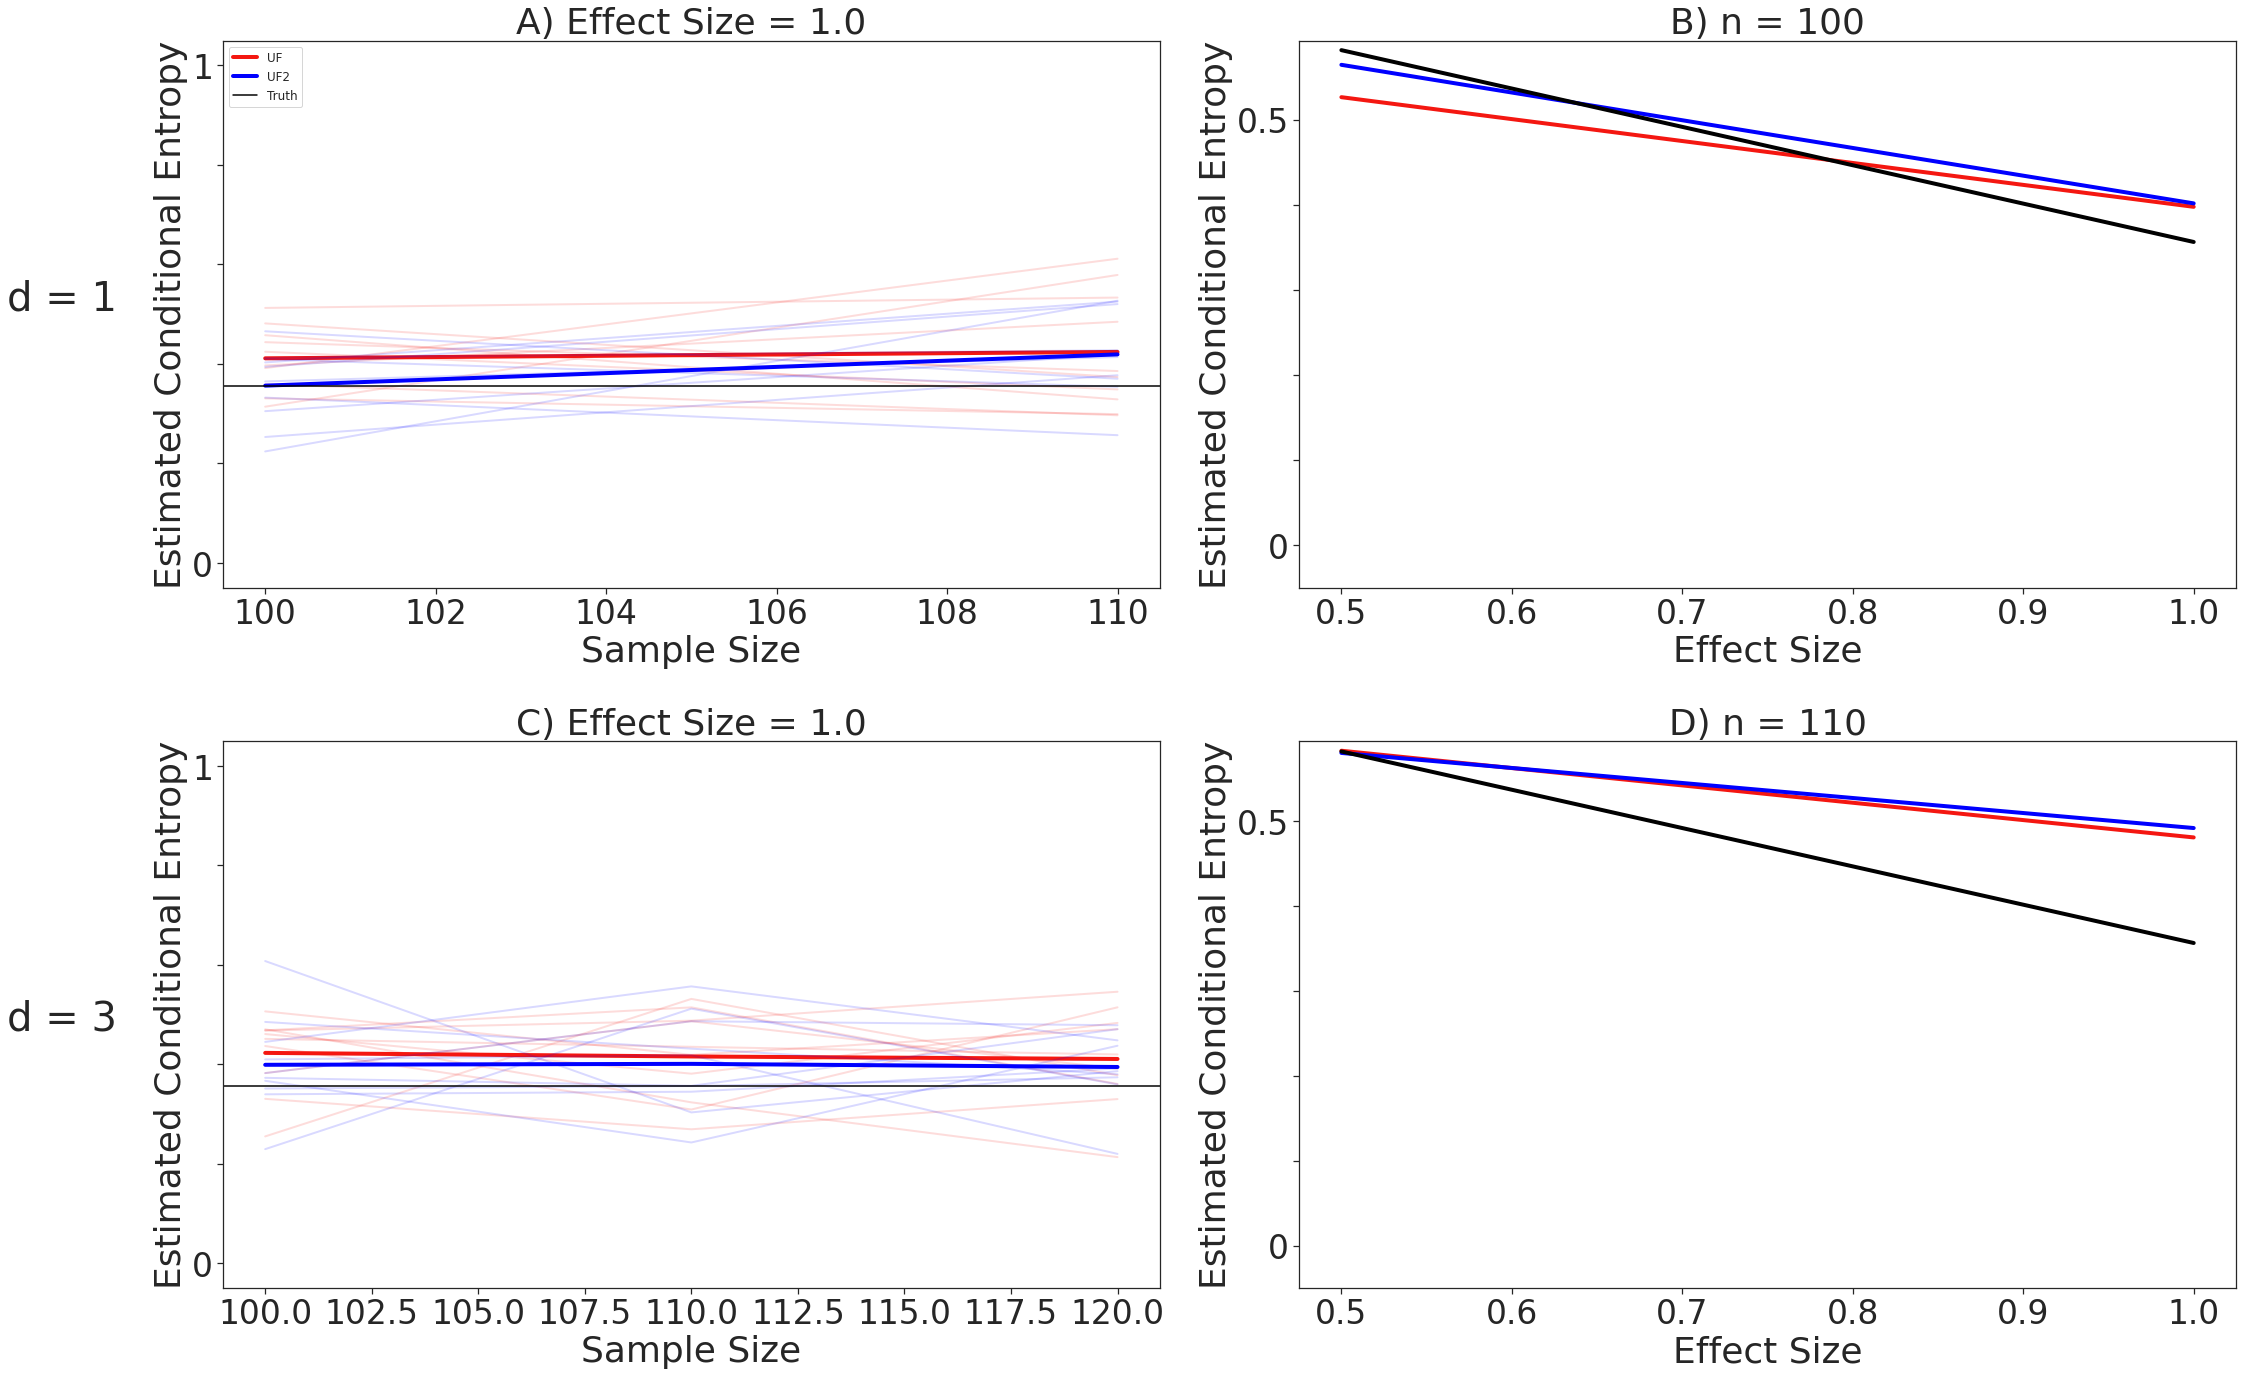

In [20]:
plot_fig2(num_plotted_trials, d1, d2, n1, n2, effect_size, algos)

In [21]:
def plot_posteriors():
    sns.set(font_scale = 3)
    sns.set_style("ticks")
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams['figure.figsize'] = [30, 20]
    fig, axes = plt.subplots(1, 2)

    # print(len(posteriors1))
    # print(len(posteriors1[0]))
    # print(len(posteriors1[1]))
    # print(len(posteriors1[2]))

    # posteriors1_nd = np.ndarray(posteriors1)
    

    # posteriors1_rs = posteriors1.reshape(len(posteriors1_nd(0))*len(posteriors1_nd), 2)

    # print(posteriors1_rs[0])

    # print(posteriors1[0][0][:])
    # print(posteriors1[0][1][:])


    for i in range(int(len(posteriors1)/1)): #len(posteriors1)
        print(i)
        for j in range(len(posteriors1[i])):
            axes[0].scatter(posteriors1[i][j][0], posteriors1[i][j][1])

    for i in range(int(len(posteriors2)/1)): #len(posteriors1)
        print(i)
        for j in range(len(posteriors2[i])):
            axes[1].scatter(posteriors2[i][j][0], posteriors2[i][j][1])
    
    # axes[0].scatter(posteriors1[0], posteriors1[1])
    # axes[1].scatter(posteriors2[0], posteriors2[1])
    
    # axes[0,0].legend(loc = "upper left")
    
    # fig.text(-0.05, 0.27, 'd = %d' % d2, ha='left', va='center', fontsize = 40)
    # fig.text(-0.05, 0.77, 'd = %d' % d1, ha='left', va='center', fontsize = 40)
    
    plt.subplots_adjust(left=-1)
    axes[0].set_title('UF1')
    axes[0].set_xlabel('Feature 1 posterior')
    axes[0].set_ylabel('Feature 2 posterior')

    axes[1].set_title('UF2')
    axes[1].set_xlabel('Feature 1 posterior')
    axes[1].set_ylabel('Feature 2 posterior')

    plt.tight_layout()    
    plt.savefig("fig2_posteriors.pdf", bbox_inches = "tight")
    plt.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89


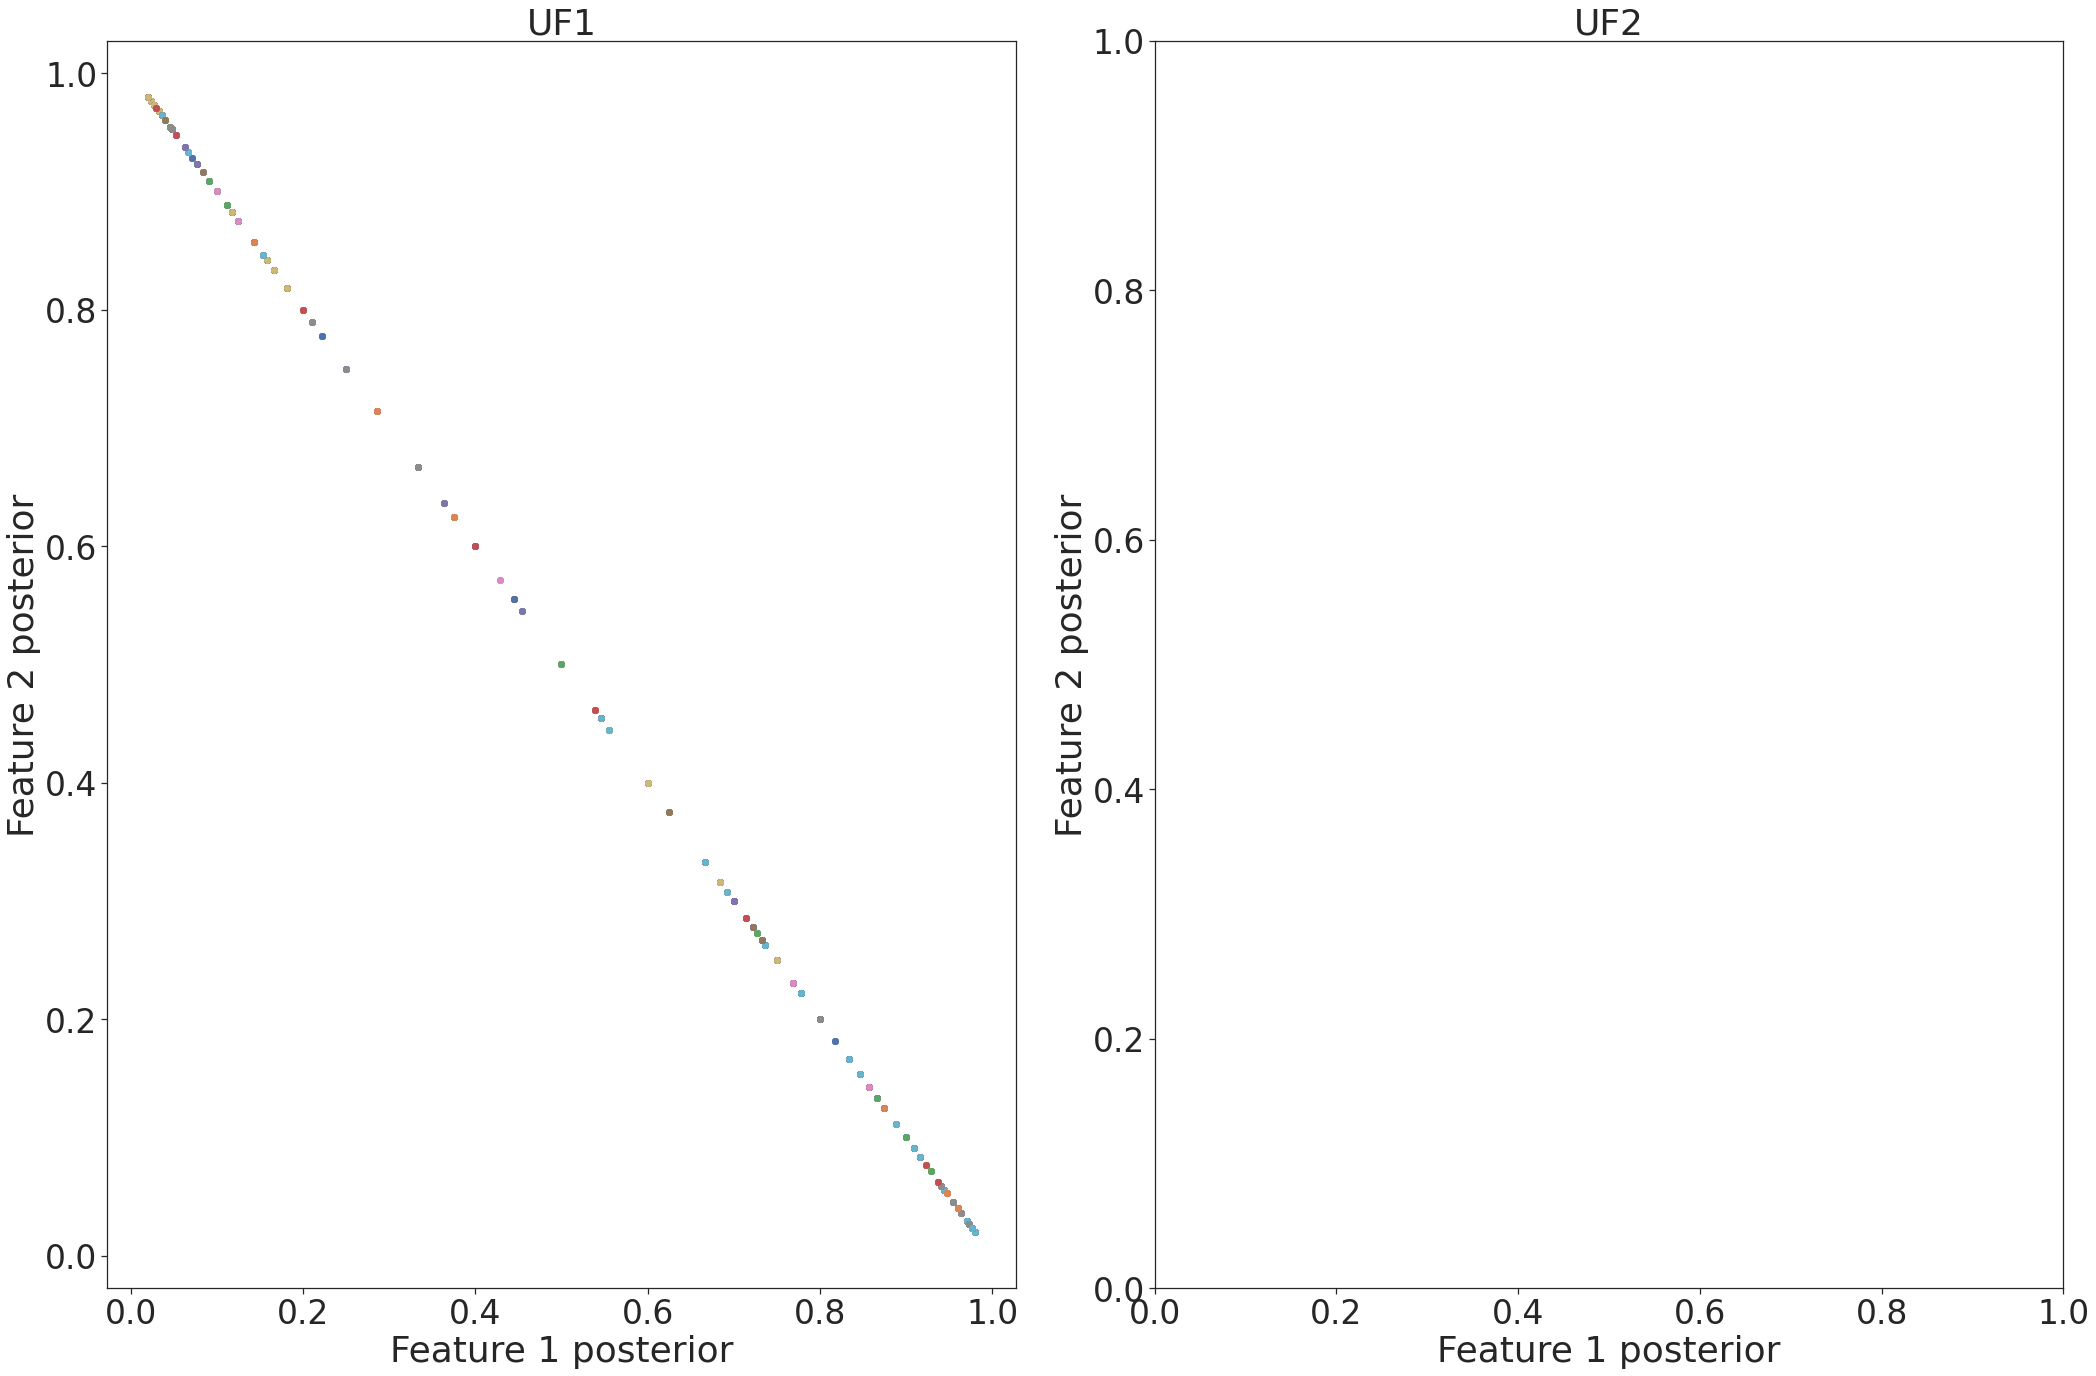

In [22]:
plot_posteriors()